<a href="https://colab.research.google.com/github/009labs/dk009dk/blob/main/Cantera%20Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install cantera

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 25.4 MB/s eta 0:00:00


In [6]:
import cantera as ct
!cantera convert gri30.xml gri30.yaml

/bin/bash: line 1: cantera: command not found


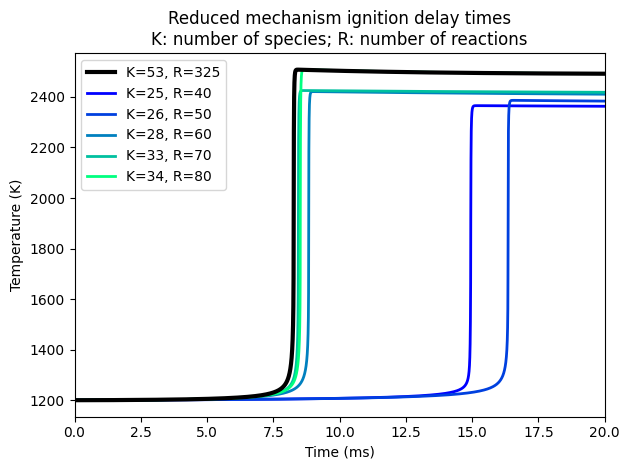

In [10]:
"""
A simplistic approach to mechanism reduction which demonstrates Cantera's
features for dynamically manipulating chemical mechanisms.

Here, we use the full GRI 3.0 mechanism to simulate adiabatic, constant pressure
ignition of a lean methane/air mixture. We track the maximum reaction rates for
each reaction to determine which reactions are the most important, according to
a simple metric based on the relative net reaction rate.

We then create a sequence of reduced mechanisms including only the top reactions
and the associated species, and run the simulations again with these mechanisms
to see whether the reduced mechanisms with a certain number of species are able
to adequately simulate the ignition delay problem.

Requires: cantera >= 2.6.0, matplotlib >= 2.0
Keywords: kinetics, combustion, reactor network, editing mechanisms, ignition delay,
          plotting
"""

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

gas = ct.Solution('gri30.yaml')
initial_state = 1200, 5 * ct.one_atm, 'CH4:0.35, O2:1.0, N2:3.76'

# Run a simulation with the full mechanism
gas.TPX = initial_state
r = ct.IdealGasConstPressureReactor(gas)
sim = ct.ReactorNet([r])

tt = []
TT = []
t = 0.0
# Rmax is the maximum relative reaction rate at any timestep
Rmax = np.zeros(gas.n_reactions)
while t < 0.02:
    t = sim.step()
    tt.append(1000 * t)
    TT.append(r.T)
    rnet = abs(gas.net_rates_of_progress)
    rnet /= max(rnet)
    Rmax = np.maximum(Rmax, rnet)

plt.plot(tt, TT, label='K=53, R=325', color='k', lw=3, zorder=100)

# Get the reaction objects, and sort them so the most active reactions are first
R = sorted(zip(Rmax, gas.reactions()), key=lambda x: -x[0])

# Test reduced mechanisms with different numbers of reactions
C = plt.cm.winter(np.linspace(0, 1, 5))
for i, N in enumerate([40, 50, 60, 70, 80]):
    # Get the N most active reactions
    reactions = [r[1] for r in R[:N]]

    # find the species involved in these reactions. At a minimum, include all
    # species in the reactant mixture
    species_names = {'N2', 'CH4', 'O2'}
    for reaction in reactions:
        species_names.update(reaction.reactants)
        species_names.update(reaction.products)

    # Get the species objects
    species = [gas.species(name) for name in species_names]

    # create the new reduced mechanism
    gas2 = ct.Solution(thermo='ideal-gas', kinetics='gas',
                       species=species, reactions=reactions)

    # save the reduced mechanism for later use
    gas2.write_yaml("gri30-reduced-{}-reaction.yaml".format(N))

    # Re-run the ignition problem with the reduced mechanism
    gas2.TPX = initial_state
    r = ct.IdealGasConstPressureReactor(gas2)
    sim = ct.ReactorNet([r])

    t = 0.0

    tt = []
    TT = []
    while t < 0.02:
        t = sim.step()
        tt.append(1000 * t)
        TT.append(r.T)

    plt.plot(tt, TT, lw=2, color=C[i],
             label='K={0}, R={1}'.format(gas2.n_species, N))
    plt.xlabel('Time (ms)')
    plt.ylabel('Temperature (K)')
    plt.legend(loc='upper left')
    plt.title('Reduced mechanism ignition delay times\n'
              'K: number of species; R: number of reactions')
    plt.xlim(0, 20)

plt.tight_layout()
plt.show()